# VAE inference walkthrough for scldm

This notebook demonstrates single-process {class}`~scldm.models.VAE` inference: reconstructing inputs and extracting latent embeddings using Hydra configs. We focus on running the pretrained VAE on out-of-distribution (OOD) data and documenting required preprocessing (gene ID mapping).

What you'll see:
- Compose the Hydra config from `experiments/configs/inference.yaml`
- Instantiate the datamodule and VAE model
- Optionally load model weights from a checkpoint
- Build a PyTorch Lightning trainer (callbacks/loggers from config)
- Run inference to obtain reconstructions and latent embeddings, then save an `.h5ad` output

# Install scldm and download artifacts needed for inference

In [1]:
import os
import pathlib

# keep track of the repo root so we know where artifacts and configs are
try:
    # make sure we re-use the path we found the first time if this is run without restarting the kernel
    NOTEBOOK_PATH = NOTEBOOK_PATH
except NameError:
    NOTEBOOK_PATH = pathlib.Path().resolve()
REPO_ROOT = NOTEBOOK_PATH.parent.parent  # assuming this notebook is in docs/notebooks
print(f"{REPO_ROOT=}")
os.chdir(REPO_ROOT)

%pip install -e . cellarium-ml@git+https://github.com/cellarium-ai/cellarium-ml.git

from scldm.download_artifacts import download_artifacts

download_artifacts(REPO_ROOT / "_artifacts", groups={"datasets", "fm_observational"})

REPO_ROOT=PosixPath('/home/ubuntu/scldm')
  Cloning https://github.com/cellarium-ai/cellarium-ml.git to /tmp/pip-install-7zvz2n1n/cellarium-ml_2b3a2b67ffbc4dda90ce5a2f67ac9f9a
  Running command git clone --filter=blob:none --quiet https://github.com/cellarium-ai/cellarium-ml.git /tmp/pip-install-7zvz2n1n/cellarium-ml_2b3a2b67ffbc4dda90ce5a2f67ac9f9a
  Resolved https://github.com/cellarium-ai/cellarium-ml.git to commit 58bc81b1e4ff51ceef51664bd99aed8af229b412
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Obtaining file:///home/ubuntu/scldm
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for scldm (pyproject.toml) ... done
  Created wheel for scldm: filename=scldm-0.0.1.dev11+g087f

## Environment and imports

We set relevant environment variables and import the modules used for VAE inference. Imports are kept local to mimic script scoping and minimize side effects.

In [2]:
# Match script behavior
os.environ["HYDRA_FULL_ERROR"] = "1"

import hydra
from omegaconf import OmegaConf

from scldm._utils import (
    process_generation_output,
    process_inference_output,
    remap_config,
    remap_pickle,
)

# Register useful resolver used in configs
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    # Already registered
    pass
print("OmegaConf resolver 'eval' registered.")

OmegaConf resolver 'eval' registered.


## Compose the Hydra config

We compose the configuration in-notebook using Hydra's `initialize`/`compose` APIs, pointing to `experiments/configs/`. Here we load `inference.yaml`; interpolations and defaults resolve as they do in the scripts.


In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf

# Initialize Hydra to read from experiments/configs - use relative path
with initialize(config_path="../../experiments/configs", version_base="1.2"):
    cfg = compose(
        config_name="inference.yaml",
        overrides=[
            "~training.logger.wandb",
            "datamodule.datamodule.test_batch_size=16",  # reduce batch size to avoid GPU OOM errors
        ],
    )

print(OmegaConf.to_yaml(cfg)[:500])  # preview

paths:
  base_data_path: _artifacts/datasets
  base_release_path: _artifacts/
  base_experiment_path: experiments/
  dataset_paths:
    dentate_gyrus:
      train: ${paths.base_data_path}/dentategyrus_train.h5ad
      test: ${paths.base_data_path}/dentategyrus_test.h5ad
      config: ${paths.base_release_path}/fm_observational/dentate_gyrus.yaml
      ckpt: ${paths.base_release_path}/fm_observational/dentate_gyrus.ckpt
      mu_size_factor: ${paths.base_release_path}/fm_observational/dentate_gyr


## Instantiate datamodule and model

We load the module configuration from `cfg.config_file`, apply `remap_config`, and instantiate:
- the {class}`~scldm.datamodule.DataModule` via `hydra.utils.instantiate(cfg.datamodule.datamodule)`
- the {class}`~scldm.models.VAE` model specified in the config (used here for inference)

In [4]:
from omegaconf import OmegaConf

# Module config file path from composed cfg
module_ckpt_path = pathlib.Path(cfg.ckpt_file)
module_config_path = pathlib.Path(cfg.config_file)

print(f"Loading module config from: {module_config_path}")
module_config = OmegaConf.load(module_config_path)
remap_config(module_config)

print("Instantiating datamodule...")
datamodule = hydra.utils.instantiate(cfg.datamodule.datamodule)

print("Instantiating model from config...")
module = hydra.utils.instantiate(module_config.model.module)

print("Datamodule and model ready.")

Loading module config from: _artifacts/vae_census/20M.yaml
Instantiating datamodule...
INFO     No train adata path provided, make sure to set up datamodule for inference                                
Instantiating model from config...
Datamodule and model ready.


## Using OOD data and mapping genes to Ensembl IDs

In this example we run the pretrained VAE on out-of-distribution (OOD) data (e.g., PBMC3k) that was not seen during training. The model expects Ensembl gene IDs, so we:
- Filter to genes present in the {class}`~scldm.encoder.VocabularyEncoderSimplified`
- Map gene symbols to Ensembl IDs
- Replace `var_names` with Ensembl IDs before inference

This ensures alignment between the OOD inputs and the model's expected gene identifier space.

In [5]:
import scanpy as sc

pbmc = sc.datasets.pbmc3k()
pbmc.var["gene_symbol"] = pbmc.var_names
# Filter genes that are present in the vocabulary encoder
available_genes = [gene for gene in pbmc.var_names if gene in datamodule.vocabulary_encoder.gene_symbol_to_ensembl]
pbmc = pbmc[:, available_genes].copy()
# Convert gene symbols to ensembl IDs and assign to var_names
pbmc.var_names = [datamodule.vocabulary_encoder.gene_symbol_to_ensembl[gene] for gene in pbmc.var_names]

datamodule.adata_inference = pbmc

INFO     Filtering genes to encoder vocabulary: kept=18862, missing=17268                                          


In [6]:
import torch

if module_ckpt_path.exists():
    print(f"Loading checkpoint weights from {module_ckpt_path}")
    checkpoint = torch.load(module_ckpt_path, map_location="cpu", pickle_module=remap_pickle, weights_only=False)
    state_dict = checkpoint["state_dict"] if isinstance(checkpoint, dict) and "state_dict" in checkpoint else checkpoint

    module_keys = set(module.state_dict().keys())
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in module_keys}

    loaded = len(filtered_state_dict)
    skipped = len(state_dict) - loaded
    missing = len(module_keys) - loaded

    if skipped:
        print(f"Skipping {skipped} keys not present in module")
    if missing:
        print(f"Module has {missing} keys not in checkpoint")
    print(f"Loading {loaded} matching keys from checkpoint")

    module.load_state_dict(filtered_state_dict, strict=False)
else:
    print(f"Checkpoint file not found: {module_ckpt_path}")

Loading checkpoint weights from _artifacts/vae_census/20M.ckpt
Skipping 178 keys not present in module
Loading 178 matching keys from checkpoint


## Build the Trainer, callbacks, and loggers

We instantiate callbacks and loggers from the training section of the config and construct a PyTorch Lightning `Trainer` with the same options used for inference runs. Seeding and runtime tweaks match the script behavior.


In [7]:
import pytorch_lightning as pl
import torch

# Match script's runtime setup
torch.set_float32_matmul_precision("high")
torch._dynamo.config.capture_scalar_outputs = True
pl.seed_everything(cfg.seed)

print("Instantiating callbacks and loggers from config...")
callbacks_list = []
for cb_cfg in getattr(cfg.training, "callbacks", {}).values():
    callbacks_list.append(hydra.utils.instantiate(cb_cfg, _partial_=False))

loggers_list = []
for lg_cfg in getattr(cfg.training, "logger", {}).values():
    loggers_list.append(hydra.utils.instantiate(lg_cfg, _partial_=False))

# Trainer is provided as a partial in config; instantiate callable first
trainer_ctor = hydra.utils.instantiate(cfg.training.trainer)  # partial

trainer = trainer_ctor(
    devices=1,
    strategy="auto",
    logger=loggers_list if len(loggers_list) > 0 else False,
    callbacks=callbacks_list,
)

# Optional cache tuning, as in script
torch.cuda.empty_cache()
torch._dynamo.config.cache_size_limit = 1000

print("Trainer ready.")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Instantiating callbacks and loggers from config...
Trainer ready.


## Run inference (reconstructions + embeddings) and save outputs

This mirrors the script's predict flow for {class}`~scldm.models.VAE` inference:
- Set the module to eval and call `datamodule.setup("predict")`
- Call `trainer.predict(module, datamodule=datamodule)`
- Post-process with {func}`~scldm._utils.process_inference_output` to build an `.h5ad` containing reconstructions and latent embeddings
- Save results to `cfg.inference_path` with dataset suffix

Note: The same code path can also run generation if configured, but this notebook focuses on inference.

In [8]:
# Predict flow
if cfg.model.module.generation_args is not None or cfg.model.module.inference_args is not None:
    module.eval()
    datamodule.setup("predict")
    output = trainer.predict(module, datamodule=datamodule)

    if cfg.model.module.generation_args is not None:
        adata = process_generation_output(output, datamodule)
    else:
        adata = process_inference_output(output, datamodule)

    inference_type = "generated" if cfg.model.module.generation_args is not None else "inference"
    adata.obs["generation_idx"] = cfg.dataset_generation_idx
else:
    print("No generation_args or inference_args specified in the config; skipping predict.")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/venv_scldm/lib/python3.11/site-packages/cellarium/ml/utilities/distributed.py:52: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
/home/ubuntu/venv_scldm/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                                 …

INFO     Processing inference output                                                                               


/home/ubuntu/venv_scldm/lib/python3.11/site-packages/cellarium/ml/utilities/distributed.py:52: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
/home/ubuntu/venv_scldm/lib/python3.11/site-packages/anndata/_core/anndata.py:1792: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Customization tips

- To switch datasets or models, adjust overrides when composing the config or edit `experiments/configs/inference.yaml`.
- Control behavior via `model.module.inference_args` (default here). `generation_args` can be used when running generation instead.
- Output location and naming are controlled by `inference_path`, `datamodule.dataset`, and `dataset_generation_idx`.


/tmp/ipykernel_9091/2096955967.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


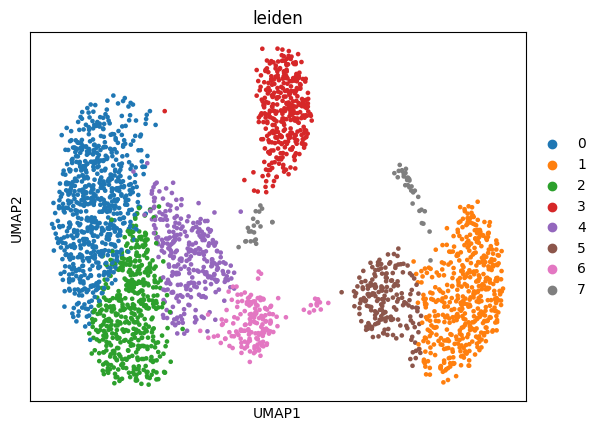

In [9]:
import scanpy as sc

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")